* sujar os dados com ruído

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.signal import detrend
from scipy.interpolate import interp1d
from scipy.fftpack import fft, fftfreq, ifft

In [2]:
class radargrama():
    def __init__(self, fname):
    
        tabela = np.loadtxt(fname)
        self.nome = fname
        self.eixo_x = np.unique(tabela[:, 0])
        self.eixo_t = np.unique(tabela[:, 1]) * 1e-9
        self.dados = detrend(np.reshape(tabela[:, 2], [len(self.eixo_x), len(self.eixo_t)]).T, axis=0)
        self.n_amostras, self.n_tracos = np.shape(self.dados)
        self.eixo_f, self.espectro = calcula_espectro(self.eixo_t, self.dados)  # retorna frequencias positivas e negativas
   

    def ganho_exp(self, tmin=0.0, a=1.0, b=1.0, x=0.0, salva=False):
        
        it = np.abs(self.eixo_t - tmin).argmin()
        
        g_t = (a * np.exp(b * self.eixo_t[it:] * 1e7)).reshape([-1,1]) + 1
        g_t = np.repeat(g_t, self.n_tracos, axis=1)
        self.dados_aux = np.concatenate((self.dados[:it, :], self.dados[it:, :] * g_t), axis=0)
            
        if not salva:
            self.plota_aux(x, f_aux=g_t[:, 0])
            
        else:
            self.dados = self.dados_aux
            self.eixo_f, self.espectro = calcula_espectro(self.eixo_t, self.dados)  # retorna frequencias positivas e negativas
            self.plota_dados(x)
        
        
    def ganho_linear(self, tmin=0.0, a=1.0, x=0.0, salva=False):
        
        it = np.abs(self.eixo_t - tmin).argmin()
        
        g_aux = [0.0, a]
        t_aux = [self.eixo_t[it], self.eixo_t[-1]]

        gf = interp1d(t_aux, g_aux)
        g_t = gf(self.eixo_t[it:]).reshape([-1,1]) + 1
        g_t = np.repeat(g_t, self.n_tracos, axis=1)
        self.dados_aux = np.concatenate((self.dados[:it, :], self.dados[it:, :] * g_t), axis=0)
            
        if not salva:
            self.plota_aux(x, f_aux=g_t[:, 0])
            
        else:
            self.dados = self.dados_aux
            self.eixo_f, self.espectro = calcula_espectro(self.eixo_t, self.dados)  # retorna frequencias positivas e negativas
            self.plota_dados(x)
            
            
    def ganho_agc(self, tw, rms=1.0, x=0.0, salva=False):
        """
        AGC instantâneo
        
        YILMAZ, O. Seismic Data Analysis, Volume I. Tulsa: Society of Exploration Geophysicists, 2008.
        """
        
        dados_norm = self.dados / np.max(np.abs(self.dados))
        nw = np.abs(self.eixo_t - (self.eixo_t[0] + tw)).argmin()   # numero de amostras dentro da janela de tempo
        g_t = np.zeros(np.shape(dados_norm))

        for w in range(nw, self.n_amostras):
            w0 = w - nw
            g_t[w0:w+1, :] = rms / np.mean(np.abs(dados_norm[w0:w+1, :]), axis=0)
        
        self.dados_aux = self.dados * g_t
        
        if not salva:
            ix = np.abs(self.eixo_x - x).argmin()
            self.plota_aux(x, f_aux=g_t[:, ix])
            
        else:
            self.dados = self.dados_aux
            self.eixo_f, self.espectro = calcula_espectro(self.eixo_t, self.dados)  # retorna frequencias positivas e negativas
            self.plota_dados(x)

            
    def passa_banda(self, f_c, x=None, salva=False):
        
        self.dados_aux = executa_filtragem(self.espectro, f_c, self.eixo_f)

        if not salva:
            # self.plota_dados(x)
            self.plota_aux(x)
            
        else:
            # self.plota_dados(x)
            self.dados = self.dados_aux
            self.eixo_f, self.espectro = calcula_espectro(self.eixo_t, self.dados)  # retorna frequencias positivas e negativas
            self.plota_dados(x)

            
    def ajusta_hiperbole(self, v, xc, t0, x=0.0, r=0.5, dx=0.5):
        """
        Ristic, A. R.; Petrovacki, D.; Govedarica, M. A new method to simultaneously estimate the radius 
        of a cylindrical object and the wave propagation velocity from GPR data. Computers & Geosciences,
        v. 35, n. 8, p. 1620-1630, 2009.
        """

        v = v * 1e9
        
        x1 = np.abs(self.eixo_x - (xc-dx)).argmin()
        x2 = np.abs(self.eixo_x - (xc+dx)).argmin()
        xi = self.eixo_x[x1:x2+1]
        ti = (2/v) * (np.sqrt(((v*t0)/2 + r)**2 + (xi - xc)**2) - r)
        
        h = {'xx': xi,
             'tt': ti}
        
        self.plota_dados(x, hiperbole=h)
        
            
            
    def tempo_profundidade(self, eps, x=0.0):
        self.eixo_z = ((3e8/np.sqrt(eps)) * self.eixo_t) / 2
        self.plota_profundidade(x)
            
            
    def plota_dados(self, x=None, hiperbole=None):
        
        if x and x <= np.max(self.eixo_x) and x >= np.min(self.eixo_x):
            i = np.abs(self.eixo_x - x).argmin()
            
        elif x and x > np.max(self.eixo_x):
            x = self.eixo_x[-1]
            i = -1
        
        elif x and x < np.min(self.eixo_x):
            x = self.eixo_x[0]
            i = 0
        
        elif not x:
            x = self.eixo_x[0]
            i = 0
        
        proporcao = (np.max(self.eixo_x) - np.min(self.eixo_x)) / (1e9*(np.max(self.eixo_t) - np.min(self.eixo_t)))
        
        fig = plt.figure(figsize=(15, 7))
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
        ax0 = plt.subplot(gs[0])
        ax0.imshow(self.dados / np.max(np.abs(self.dados)), extent=[self.eixo_x[0], self.eixo_x[-1], \
                                                                    self.eixo_t[-1]*1e9, self.eixo_t[0]*1e9], cmap='bwr_r')
        ax0.plot([x, x], [np.min(self.eixo_t)*1e9, np.max(self.eixo_t)*1e9], '--k', linewidth=1.0)
        
        if hiperbole is not None:
            ax0.plot(hiperbole['xx'], hiperbole['tt']*1e9, '-k')
        
        ax0.set_title(self.nome, fontsize=14)
        ax0.set_xlabel('Distância (m)', fontsize=14)
        ax0.set_ylabel('Tempo (ns)', fontsize=14)
        ax0.set_aspect(proporcao)
        ax0.grid()
        
        ax1 = plt.subplot(gs[1])
        ax1.plot(self.dados[:, i] / np.max(np.abs(self.dados[:, i])), self.eixo_t*1e9)
        ax1.set_title('Traço em ' + str(x) + ' m', fontsize=14)
        ax1.set_xlabel('Amplitude normalizada', fontsize=14)
        ax1.set_ylabel('Tempo (ns)', fontsize=14)
        ax1.grid()
        ax1.set_ylim([np.min(self.eixo_t)*1e9, np.max(self.eixo_t)*1e9])
        ax1.set_xlim([-1.2, 1.2])
        ax1.invert_yaxis()
        
        plt.tight_layout()
        plt.show()
        
        

    def plota_aux(self, x=None, f_aux=None):

        if x and x <= np.max(self.eixo_x) and x >= np.min(self.eixo_x):
            i = np.abs(self.eixo_x - x).argmin()
            
        elif x and x > np.max(self.eixo_x):
            x = self.eixo_x[-1]
            i = -1
        
        elif x and x < np.min(self.eixo_x):
            x = self.eixo_x[0]
            i = 0
        
        elif not x:
            x = self.eixo_x[0]
            i = 0

        proporcao = (np.max(self.eixo_x) - np.min(self.eixo_x)) / (1e9*(np.max(self.eixo_t) - np.min(self.eixo_t)))

        fig = plt.figure(figsize=(15, 7))
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
        ax0 = plt.subplot(gs[0])
        ax0.imshow(self.dados_aux / np.max(np.abs(self.dados_aux)), extent=[self.eixo_x[0], self.eixo_x[-1], \
                                                                    self.eixo_t[-1]*1e9, self.eixo_t[0]*1e9], cmap='bwr_r')
        ax0.plot([x, x], [np.min(self.eixo_t)*1e9, np.max(self.eixo_t)*1e9], '--k', linewidth=1.0)
        ax0.set_title(self.nome + ' (temporário)', fontsize=14)
        ax0.set_xlabel('Distância (m)', fontsize=14)
        ax0.set_ylabel('Tempo (ns)', fontsize=14)
        ax0.set_aspect(proporcao)
        ax0.grid()

        ax1 = plt.subplot(gs[1])
        ax1.plot(self.dados_aux[:, i] / np.max(np.abs(self.dados_aux[:, i])), self.eixo_t*1e9, label='traço após\no ganho')
        
        
        if f_aux is not None:
            ax1.plot(f_aux/np.max(f_aux), self.eixo_t[(len(self.eixo_t)-len(f_aux)):]*1e9, '-r', label='função de ganho')
            ax1.legend()
        
        
        ax1.set_title('Traço em ' + str(x) + ' m', fontsize=14)
        ax1.set_xlabel('Amplitude normalizada', fontsize=14)
        ax1.set_ylabel('Tempo (ns)', fontsize=14)
        ax1.grid()
        ax1.set_ylim([np.min(self.eixo_t)*1e9, np.max(self.eixo_t)*1e9])
        ax1.set_xlim([-1.2, 1.2])
        ax1.invert_yaxis()

        plt.tight_layout()
        plt.show()
            

    def plota_espectro(self):
        n_samples = self.n_amostras       # vai ser o mesmo número de amostras do sinal porque a fft não usou zeros adicionais

        nf_positivas = round(n_samples / 2) + 1     # número de frequências positivas
        amplitudes = (2 / n_samples) * np.abs(self.espectro[:nf_positivas])
        frequencias = self.eixo_f[:nf_positivas] * 1e-6

        fig, ax = plt.subplots(figsize=(15,5))
        ax.plot(frequencias, np.mean(amplitudes, axis=1))
        ax.set_xlabel('Frequência (MHz)', fontsize=14)
        ax.set_ylabel('Amplitude (ua)', fontsize=14)
        ax.set_xlim([0, np.max(frequencias)/4])
        ax.set_ylim([0, np.max(np.mean(amplitudes, axis=1))*1.05])
        ax.set_title("Espectro de amplitudes do sinal original", fontsize=14)
        ax.grid()
        
    
    def plota_filtragem(self, f_c):
        """
        Apenas plota a representação da seleção de frequências com o filtro sobre a parte
        positiva do espectro, porém não executa a filtragem propriamente dita    
        """

        n_samples = self.n_amostras       # vai ser o mesmo número de amostras do sinal porque a fft não usou zeros adicionais
        nf_positivas = round(n_samples / 2) + 1     # número de frequências positivas
        amplitudes = (2 / n_samples) * np.abs(self.espectro[:nf_positivas])
        pos_ff = self.eixo_f[:nf_positivas] * 1e-6

        filtro = gera_filtro(f_c, self.eixo_f)
        escala_filtro = np.max(np.mean(amplitudes, axis=1)) + 0.05 * np.max(np.mean(amplitudes, axis=1))   # escala gráfica para plotar o contorno do filtro

        fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(13,7))
        ax[0].plot(pos_ff, np.mean(amplitudes, axis=1))
        ax[0].plot(pos_ff, filtro[:nf_positivas] * escala_filtro, '--r')
        ax[0].set_xlabel('Frequência (MHz)', fontsize=14)
        ax[0].set_ylabel('Amplitude (ua)', fontsize=14)
        ax[0].set_xlim([0, np.max(pos_ff)/4])
        ax[0].set_ylim([0, np.max(np.mean(amplitudes, axis=1))*1.1])
        ax[0].set_title("Filtro passa-banda sobre o espectro", fontsize=14)
        ax[0].grid()

        ax[1].plot(pos_ff, np.mean(amplitudes, axis=1) * filtro[:nf_positivas])
        ax[1].set_xlabel('Frequência (MHz)', fontsize=14)
        ax[1].set_ylabel('Amplitude (ua)', fontsize=14)
        ax[1].set_xlim([0, np.max(pos_ff)/4])
        ax[1].set_ylim([0, np.max(np.mean(amplitudes, axis=1))*1.1])
        ax[1].set_title("Frequências remanescentes após a filtragem", fontsize=14)
        ax[1].grid()

        plt.tight_layout()
        
            
    def plota_profundidade(self, x=None):
        
        if x and x <= np.max(self.eixo_x) and x >= np.min(self.eixo_x):
            i = np.abs(self.eixo_x - x).argmin()
            
        elif x and x > np.max(self.eixo_x):
            x = self.eixo_x[-1]
            i = -1
        
        elif x and x < np.min(self.eixo_x):
            x = self.eixo_x[0]
            i = 0
        
        elif not x:
            x = self.eixo_x[0]
            i = 0
        
        proporcao = (np.max(self.eixo_x) - np.min(self.eixo_x)) / (np.max(self.eixo_z) - np.min(self.eixo_z))
        
        fig = plt.figure(figsize=(15, 7))
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
        ax0 = plt.subplot(gs[0])
        ax0.imshow(self.dados / np.max(np.abs(self.dados)), extent=[self.eixo_x[0], self.eixo_x[-1], \
                                                                    self.eixo_z[-1], self.eixo_z[0]], cmap='bwr_r')
        ax0.plot([x, x], [np.min(self.eixo_z), np.max(self.eixo_z)], '--k', linewidth=1.0)
        ax0.set_title(self.nome + ' (Não migrado)', fontsize=14)
        ax0.set_xlabel('Distância (m)', fontsize=14)
        ax0.set_ylabel('Profundidade (m)', fontsize=14)
        ax0.set_aspect(proporcao)
        ax0.grid()
        
        ax1 = plt.subplot(gs[1])
        ax1.plot(self.dados[:, i] / np.max(np.abs(self.dados[:, i])), self.eixo_z)
        ax1.set_title('Traço em ' + str(x) + ' m', fontsize=14)
        ax1.set_xlabel('Amplitude normalizada', fontsize=14)
        ax1.set_ylabel('Profundidade (m)', fontsize=14)
        ax1.grid()
        ax1.set_ylim([np.min(self.eixo_z), np.max(self.eixo_z)])
        ax1.set_xlim([-1.2, 1.2])
        ax1.invert_yaxis()
        
        plt.tight_layout()
        plt.show()
            
            
def calcula_espectro(tt, ss):
    
    dt = tt[1] - tt[0]
    n_amostras = len(ss)

    espectro = fft(ss, axis=0)
    ff = fftfreq(len(ss), dt)
    
    return ff, espectro


def gera_filtro(f_c, ff):
    i_max_freq = np.abs(ff-np.max(ff)).argmin()   # indice da máxima frequência positiva
    delta_rampa = ff[1] - ff[0]     # a largura das rampas é de apenas 1 delta_f

    amp_caixa = [0, 0, 1, 1, 0, 0]                      # amplitudes da caixa do filtro na parte positiva do espectro
    f_rampa_sub = f_c[0] - delta_rampa                                # frequência no início da rampa do filtro
    f_rampa_desc = f_c[1] + delta_rampa                               # frequência no fim da rampa do filtro
    f_caixa_pos = np.array([ff[0], f_rampa_sub, f_c[0], f_c[1], \
                            f_rampa_desc, np.max(ff)])                # caixa para a parte positiva do espectro

    # espelhamento da caixa na parte positiva do espectro
    f_caixa_neg = np.flip(-1 * f_caixa_pos)   # caixa para a parte negativa do espectro
    f_caixa_neg[-1] = ff[-1]
    f_caixa_neg[0] = ff[i_max_freq+1]

    # interpolação das funções caixa para as frequências do espectro
    caixa_pos = interp1d(f_caixa_pos, amp_caixa, kind='linear')
    caixa_neg = interp1d(f_caixa_neg, np.flip(amp_caixa), kind='linear')

    return np.concatenate([caixa_pos(ff[:i_max_freq+1]), caixa_neg(ff[i_max_freq+1:])], axis=0)


def executa_filtragem(espec, f_c, ff):
    filtro = gera_filtro(f_c, ff)
    filtro = np.reshape(filtro, [-1,1])
    filtro = np.repeat(filtro, np.shape(espec)[1], axis=1)
    
    return np.real(ifft(espec * filtro, axis=0))

    

    
    
def showspec(ff, espec):
    n_samples = np.shape(espec)[0]       # vai ser o mesmo número de amostras do sinal porque a fft não usou zeros adicionais

    nf_positivas = round(n_samples / 2) + 1     # número de frequências positivas
    amplitudes = (2 / n_samples) * np.abs(espec[:nf_positivas])
    frequencias = ff[:nf_positivas]
    
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(frequencias, np.mean(amplitudes, axis=1))
    ax.set_xlabel('Frequência (MHz)', fontsize=14)
    ax.set_ylabel('Amplitude (ua)', fontsize=14)
    ax.set_xlim([0, np.max(frequencias)/4])
    ax.set_ylim([0, np.max(np.mean(amplitudes, axis=1))*1.05])
    ax.set_title("Espectro de amplitudes do sinal original", fontsize=14)
    ax.grid()

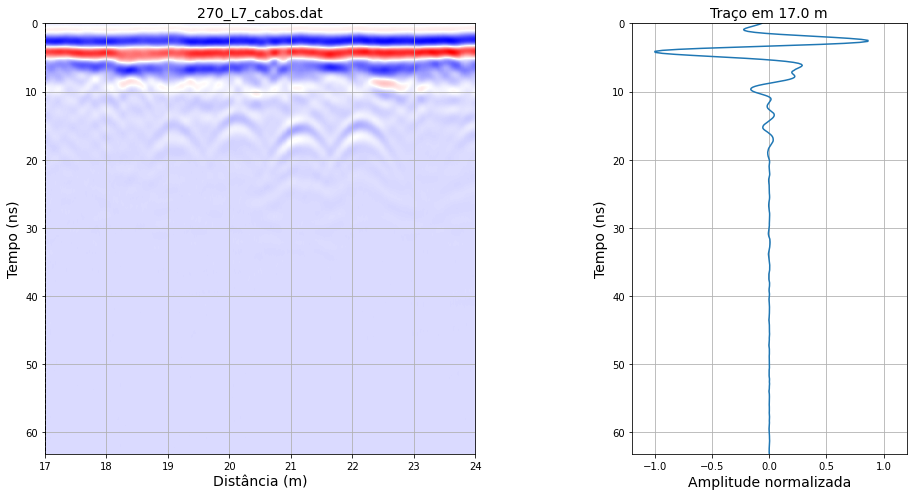

In [3]:
dados = radargrama('270_L7_cabos.dat')
dados.plota_dados(x=1.1)

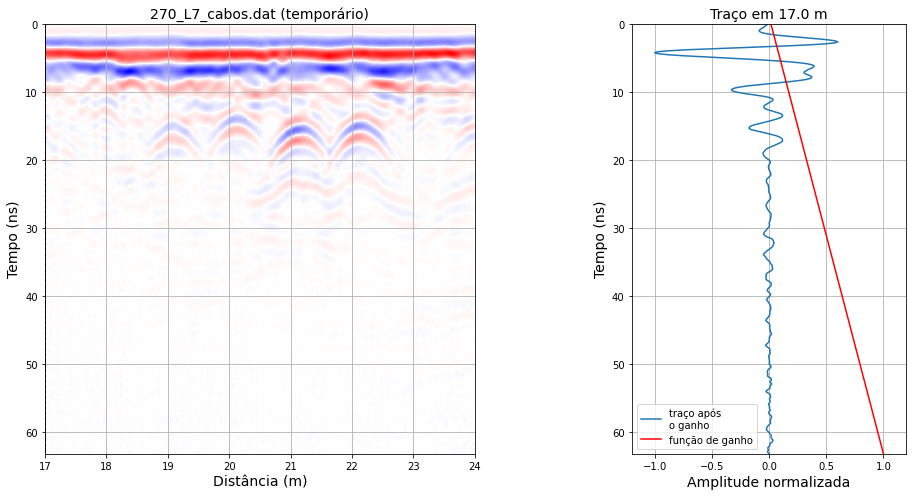

In [4]:
dados.ganho_linear(a=60.0, x=1.1, salva=False)

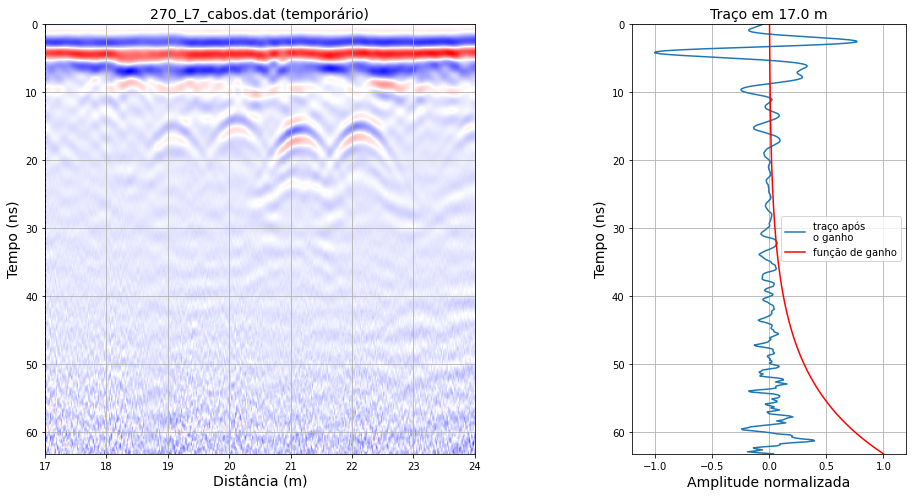

In [5]:
dados.ganho_exp(a=3.0, b=9.0, x=1.1, salva=False)

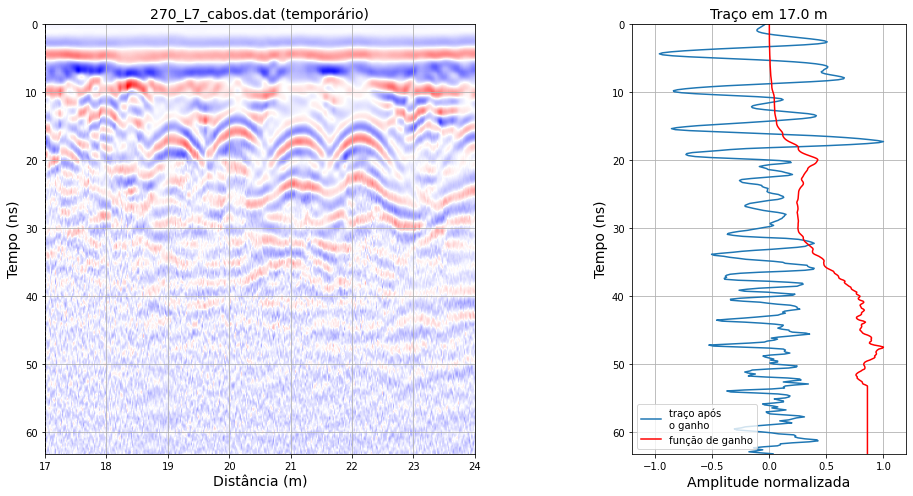

In [6]:
dados.ganho_agc(tw=10e-9, salva=False)

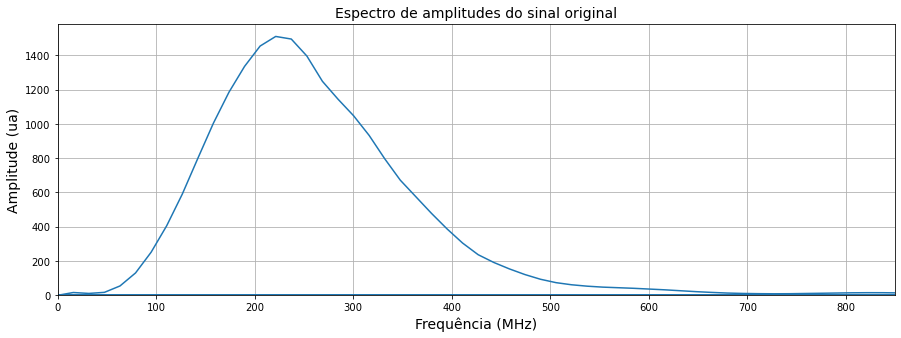

In [7]:
dados.plota_espectro()

In [8]:
freq_corte = [100e6, 500e6]

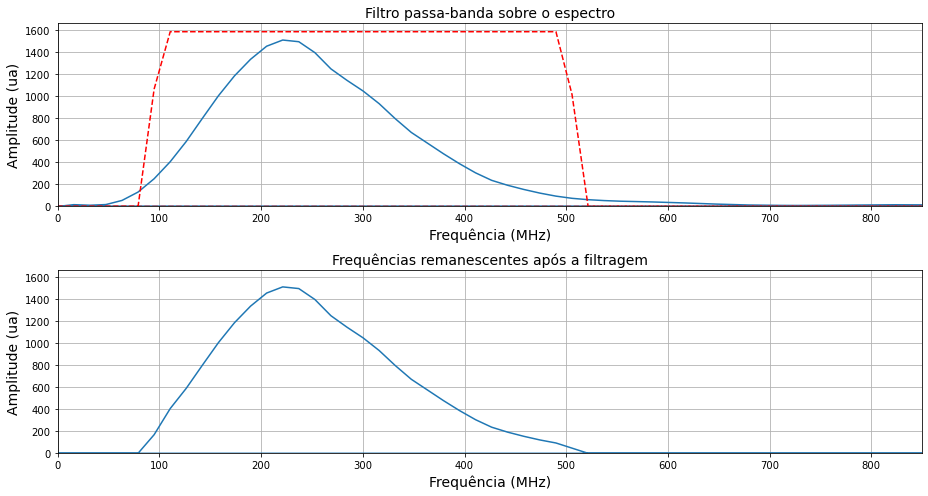

In [9]:
dados.plota_filtragem(f_c = freq_corte)

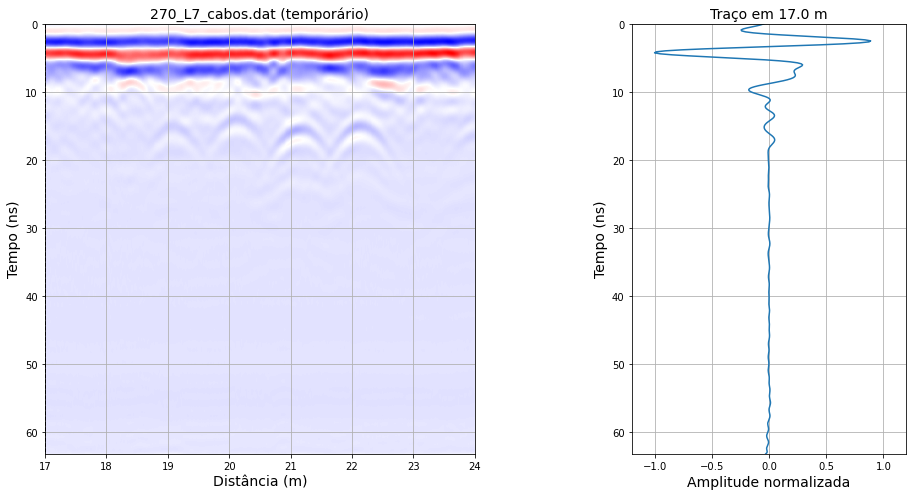

In [10]:
dados.passa_banda(freq_corte, x=1.1, salva=False)

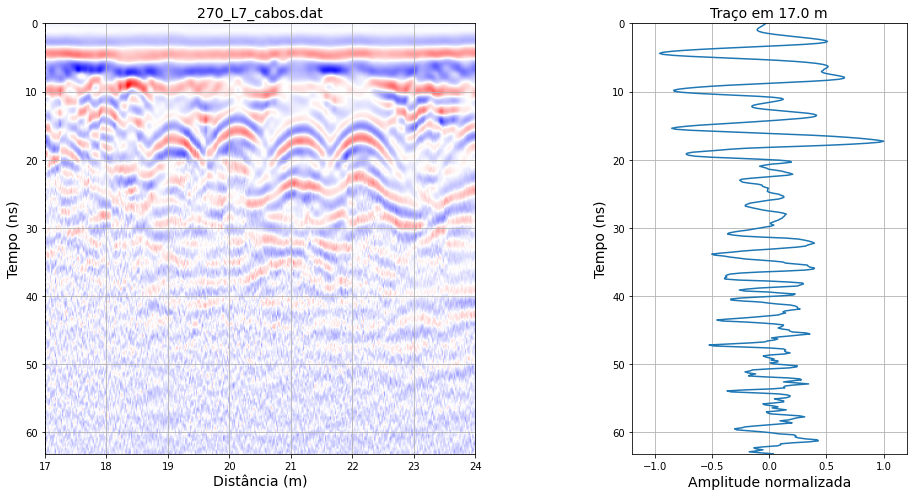

In [11]:
dados.ganho_agc(tw=10e-9, x=1.1, salva=True)

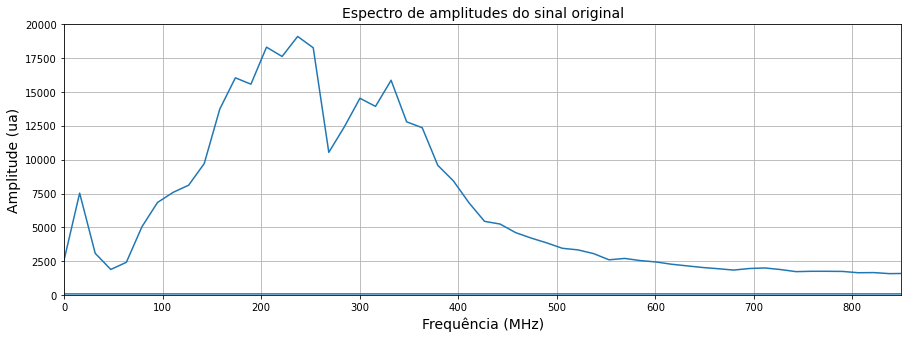

In [12]:
dados.plota_espectro()

In [13]:
freq_corte2 = [150e6, 400e6]

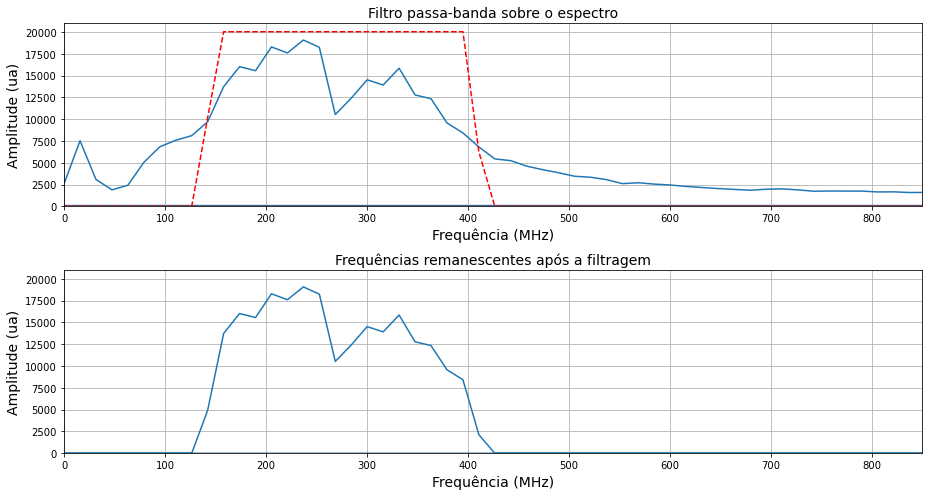

In [14]:
dados.plota_filtragem(f_c = freq_corte2)

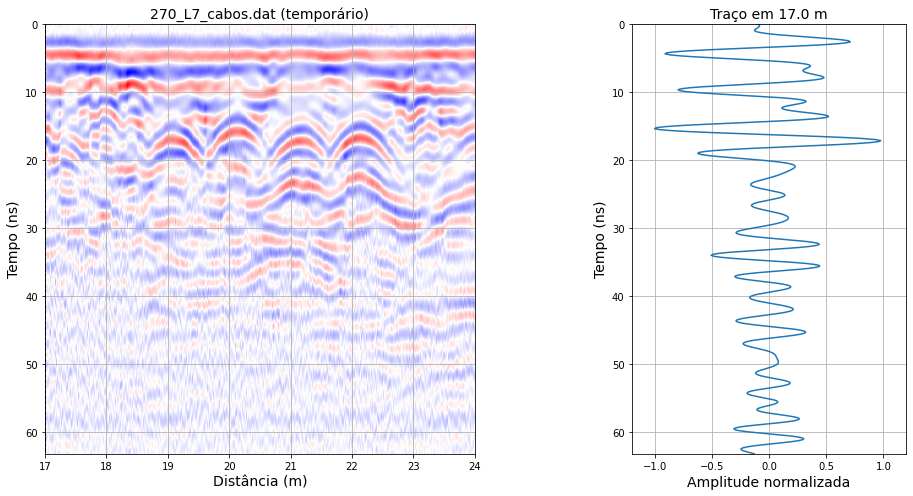

In [15]:
dados.passa_banda(freq_corte2, x=1.1, salva=False)

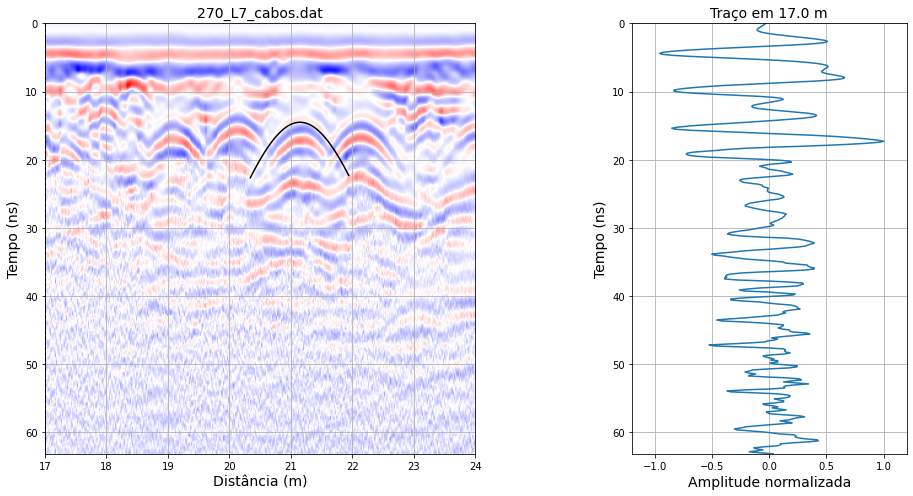

In [16]:
dados.ajusta_hiperbole(v=0.070, xc=21.15, dx=0.8, t0=14.5e-9, r=0.5)

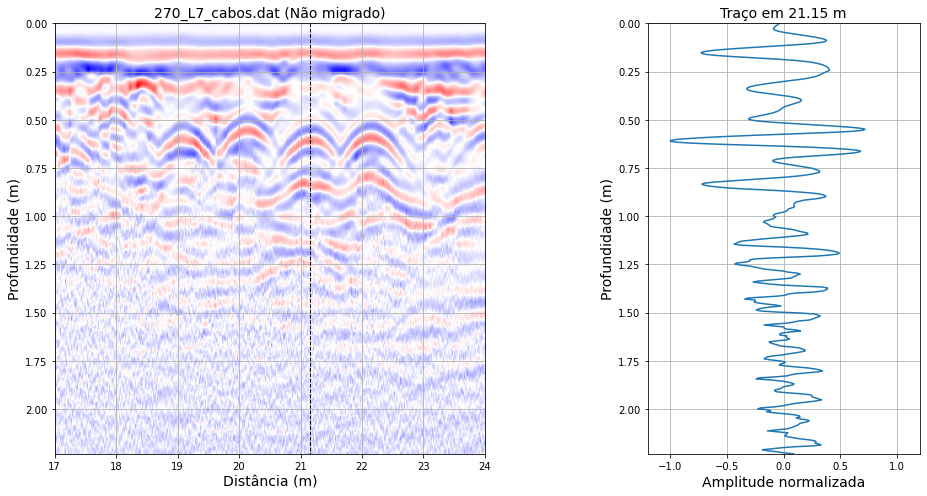

In [17]:
dados.tempo_profundidade(eps=18, x=21.15)